In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import re
import seaborn as sn
from sklearn.model_selection import train_test_split
import gc
import keras
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from keras.optimizers import RMSprop

Using TensorFlow backend.


In [2]:
max_features = 10
space_letter = 0

training_data = pd.read_csv('D:/Notebook/Text_Normalization_Dataset_English/en_train.csv')
training_data = training_data.head(30000)
training_data['class'].unique()

array(['PLAIN', 'PUNCT', 'DATE', 'LETTERS', 'CARDINAL', 'VERBATIM',
       'DECIMAL', 'MEASURE', 'MONEY', 'ORDINAL', 'TIME', 'ELECTRONIC',
       'DIGIT', 'FRACTION', 'TELEPHONE'], dtype=object)

In [3]:
y_data, labels = pd.factorize(training_data['class'])
gc.collect()

5

In [4]:
def get_ascii_value(training_data):
  x_data = []
  for before_value in training_data['before'].values:
    row = np.ones(max_features, dtype=int) * space_letter
    for before_value_char, i in zip(list(str(before_value)), np.arange(max_features)):
        row[i] = ord(before_value_char)
    x_data.append(row)
  return x_data

In [5]:
x_data=get_ascii_value(training_data)

In [6]:
def make_batch(data, row_size, max_features, end_indicater):
    pad = np.zeros(shape=max_features)
    pads = [pad for _ in  np.arange(row_size)]
    data = pads + data + pads
    batchs = []
    for lower_bound in np.arange(len(data) - row_size * 2):
        batch = []
        batch_size = row_size * 2 + 1
        upper_bound = lower_bound + batch_size
        context_window = data[lower_bound:upper_bound]
        for word in context_window:
            batch.append([end_indicater])
            batch.append(word)
        batch.append([end_indicater])
        batchs.append([int(word) for row in batch for word in row])
    return batchs

In [7]:
x_data = x_data[:len(training_data)]
y_data = y_data[:len(training_data)]
x_data = np.array(make_batch(x_data, row_size = 1, max_features= max_features, end_indicater=-1))
gc.collect()

0

In [8]:
x_train = np.array(x_data)
y_train = np.array(y_data)
gc.collect()

0

In [9]:
x_train, x_valid, y_train, y_valid = train_test_split(x_train, y_train, test_size=0.1)

In [10]:
y_train = keras.utils.to_categorical(y_train, len(labels))
y_valid = keras.utils.to_categorical(y_valid, len(labels))
print(x_train.shape)

(27000, 34)


In [11]:
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
x_valid = np.reshape(x_valid, (x_valid.shape[0], x_valid.shape[1], 1))

In [13]:
model = Sequential()
model.add(LSTM(128, dropout=0.2, recurrent_dropout=0.2, input_shape=((max_features * 3) + 4, 1)))
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(len(labels), activation='softmax'))

In [15]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 128)               66560     
_________________________________________________________________
dense_1 (Dense)              (None, 32)                4128      
_________________________________________________________________
dropout_1 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 15)                495       
Total params: 71,183
Trainable params: 71,183
Non-trainable params: 0
_________________________________________________________________


In [16]:
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

In [17]:
result = model.fit(x_train, y_train, batch_size=256, epochs=30, verbose=1, validation_data=(x_valid, y_valid))

Train on 27000 samples, validate on 3000 samples
Epoch 1/30
27000/27000 [==============================] - 14s 519us/step - loss: 0.8518 - acc: 0.7730 - val_loss: 0.3584 - val_acc: 0.9170
Epoch 2/30
27000/27000 [==============================] - 12s 438us/step - loss: 0.4286 - acc: 0.8989 - val_loss: 0.3895 - val_acc: 0.8693
Epoch 3/30
27000/27000 [==============================] - 12s 437us/step - loss: 0.3464 - acc: 0.9201 - val_loss: 0.2601 - val_acc: 0.9227
Epoch 4/30
27000/27000 [==============================] - 12s 439us/step - loss: 0.2995 - acc: 0.9287 - val_loss: 0.4846 - val_acc: 0.8697
Epoch 5/30
27000/27000 [==============================] - 12s 439us/step - loss: 0.2590 - acc: 0.9347 - val_loss: 0.1915 - val_acc: 0.9460
Epoch 6/30
27000/27000 [==============================] - 12s 439us/step - loss: 0.2403 - acc: 0.9406 - val_loss: 0.3484 - val_acc: 0.9110
Epoch 7/30
27000/27000 [==============================] - 12s 435us/step - loss: 0.2223 - acc: 0.9451 - val_loss: 0.3

In [18]:
gc.collect()

0

In [19]:
score = model.evaluate(x_valid, y_valid, verbose=0)

In [20]:
print("Accuracy==>",score[1])

Accuracy==> 0.777666666507721


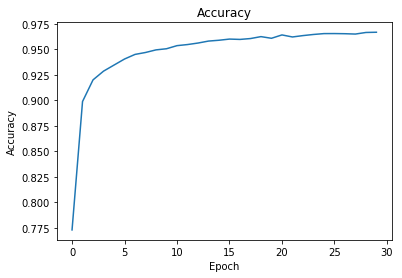

In [21]:
plt.plot(result.history['acc'])
plt.title("Accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.show()

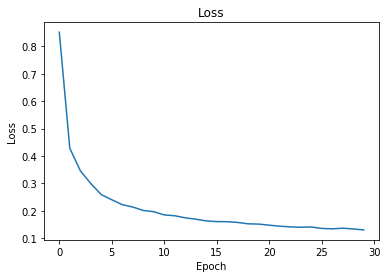

In [22]:
plt.plot(result.history['loss'])
plt.title('Loss')
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.show()

In [23]:
predicted_valid = model.predict(x_valid)

In [24]:
predicted_valid = [labels[np.argmax(x)] for x in predicted_valid]
x_valid = [[chr(x) for x in y[2 + max_features: 2 + max_features * 2]] for y in x_valid]
x_valid = [''.join(x) for x in x_valid]
x_valid = [re.sub('a+$', '', x) for x in x_valid]

In [25]:
gc.collect()

4786

In [26]:
df_predicted_valid = pd.DataFrame(columns=['data', 'predict'])
df_predicted_valid['data'] = x_valid
df_predicted_valid['predict'] = predicted_valid
df_predicted_valid.to_csv('validation_pred_lstm.csv')

In [27]:
df_predicted_valid.head(30)

,data,predict
0,convert   ,PLAIN
1,because   ,PLAIN
2,only      ,PLAIN
3,were      ,PLAIN
4,short     ,PLAIN
5,Her       ,LETTERS
6,Camp      ,LETTERS
7,succeeded ,PLAIN
8,in        ,PLAIN
9,",         ",PUNCT


In [28]:
all_classes = set(training_data['class'].unique())
predicted_classes = set(df_predicted_valid['predict'].unique())
missed_classes = all_classes - predicted_classes

In [29]:
for cls in missed_classes: print(cls)

TELEPHONE
ORDINAL
MEASURE
DIGIT
TIME
FRACTION
DECIMAL
ELECTRONIC
MONEY
